In [1]:
import warnings
warnings.filterwarnings('ignore' )
import numpy as np
import torch

# Intensity model
from model import Model

# Optimization functions
from solver import compute_loss, optimizer, training_loop

#Plot intensity and learned kernels
from utils_plot import plot_global_fig, check_tensor

#Simulate Poisson process
from simu_pp import simu

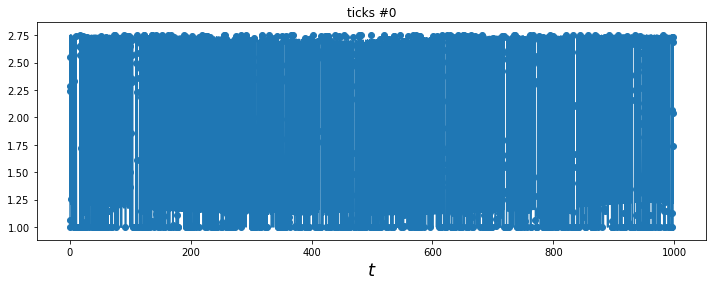

True parameters: [1.  0.7 0.4 0.4]
Initial parameters: [0.87481858 0.93015172 0.42472445 0.60427766]
Fitting model... done (4.0 s.) 
Estimated parameters: [1.00403166 0.75896497 0.39743451 0.40014912]


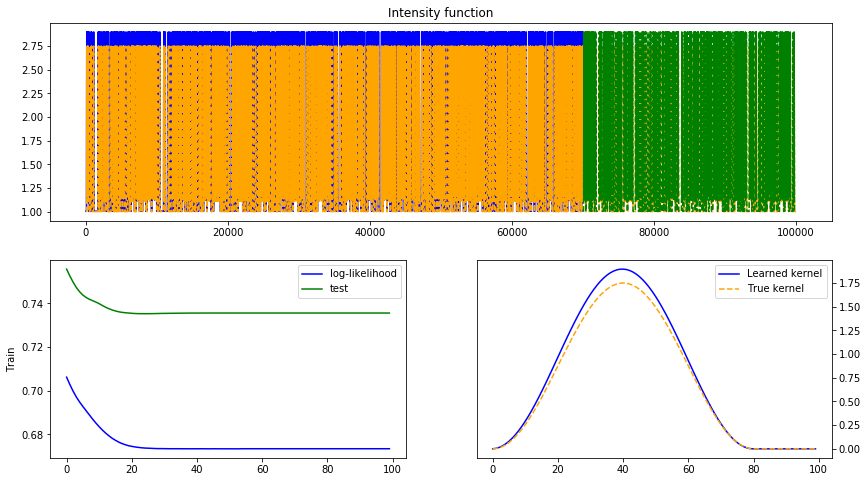

In [5]:
# model parameters
mu_0, alpha_true, mu_true, sig_true   = 1, 0.7, 0.4, 0.4
true_params = np.array([mu_0, alpha_true, mu_true, sig_true])

# simulation parameters
#seed = 42
seed = None
T = 1000
L = 100
dt = 1 / L
p_task = 0.6

# simulate data
true_kernel, true_intensity, driver_tt, acti_tt, in_poi = simu(
    true_params, simu_params=[T, L, p_task], seed=seed, plot_intensity=True)



# initialize parameters
rng = np.random.RandomState(seed=seed)
p = 1  # init parameters are +- p% around true parameters
init_params = rng.uniform(low=true_params*(1-p), high=true_params*(1+p))
init_params = init_params.clip(1e-5)
print(f"True parameters: {true_params}")
print(f"Initial parameters: {init_params}")

#### Optimization ####

# parameters
loss_name = 'log-likelihood'  # 'log-likelihood' | 'MSE'
max_iter = 100
step_size = 1e-2
solver = 'Adam' # 'GD' | 'RMSprop' | 'Adam' | 'LBFGS' 
kernel_name = 'raised_cosine' # 'raised_cosine' | 'gaussian'
t = torch.arange(0, 1, dt)

# int to have a train/test split, otherwise set at 0 or False
test = 0.3  

# run gradient descent
model_raised = Model(t, check_tensor(init_params), dt, kernel_name, loss_name)

opt =  optimizer(model_raised.parameters(), step_size, solver)

res_dict = training_loop(model_raised, opt, driver_tt, acti_tt, max_iter, test)

# plot final figure
fig = plot_global_fig(true_intensity, est_intensity=res_dict['est_intensity'],
                          true_kernel=true_kernel, est_kernel=res_dict['est_kernel'],
                          pobj=res_dict['pobj'], test_intensity=res_dict['test_intensity'],
                          pval=res_dict['pval'], loss=loss_name)

driver_torch_temp = torch.tensor(driver_tt).double()
acti_torch_temp = torch.tensor(acti_tt).double()